In [123]:
import nltk
import math
import numpy as np  
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [124]:
def loadPath():
    for line in open('Sarcasm_Headlines_Dataset.json','r'):
        yield eval(line)

In [125]:
def loadData():
    data=list(formatData())
    
    #Importing Stoplist
    stopWord=open("Stopword-List.txt").read()
    stopWord=nltk.word_tokenize(stopWord)

    return data,stopWord

In [126]:
def splitData():
    X=[]
    Y=[]
    
    for i in range(len(Data)):
        X.append(Data[i]['headline'])
        Y.append(Data[i]['is_sarcastic'])
        
    return X,Y

In [127]:
def TokenizeData(X,freq=3):
    #Tokens
    wordsTORemove=[]
    tokens=[]
    for i in range(size):
        temp=nltk.word_tokenize(X[i])
        for j in range(len(temp)):
            tokens.append(temp[j])
            
    #Decapitalized
    tokens=[element.lower() for element in tokens]
    
    #Remove Special characters
    removetable=str.maketrans("", "", "'!@#$%^&*()_=-\|][:';:,<.>/?`~0123456789")
    tokens=[x.translate(removetable) for x in tokens]
    
    #Removing StopWords
    tokens=[x for x in tokens if x.isalnum() and x not in stopWord]
    
    #word Frequency
    fdist=nltk.FreqDist(tokens)
    
    #Unique Tokens 
    tokens=list(set(tokens))
    
    #Counting Frequency
    #Removing words freq <=3
    for words in tokens:
        if(fdist[words]<=freq):
            tokens.remove(words)
            wordsTORemove.append(words)
            
    #Removing Token Tags
    tagg=nltk.tag.pos_tag(tokens)
    taggs=set()
    for word,type1 in tagg:
        if(type1=='NNP' or type1=='FW' or type1=='PRP'):
            taggs.add(word)    
            
    tokens=list(set(tokens)-taggs)
    
    #Removing words with length 2
    for words in tokens:
        if len(words)<=2:
            tokens.remove(words)
            wordsTORemove.append(words)
            
    
    return tokens,taggs,wordsTORemove

In [128]:
def processData():
    #Tokens
    docToken=[]
    for i in range(size):
        docToken.append(nltk.word_tokenize(X[i])) 
        
    
    #Decaptilized Doc Wise
    for x in range(size):
        docToken[x]=[element.lower() for element in docToken[x]]
        
    #Remove Special characters Doc Wise
    removetable=str.maketrans("", "", "'!@#$%^&*()_=-\|][:';:,<.>/?`~")
    for x in range(size):
        docToken[x]=[y.translate(removetable) for y in docToken[x]]
        
    #removing StopWords
    for x in range(size):
        docToken[x]=[y for y in docToken[x] if y.isalnum() and y not in stopWord]
        
    #Removing Token Tags
    for x in range(size):
        docToken[x]=list(set(docToken[x])-taggs)
        
    # Counting Frequency
    # Removing words freq <=3
    for x in range(size):
        for words in docToken[x]:
            if len(words)<=2:
                docToken[x].remove(words)
            elif words in wordsTORemove:
                docToken[x].remove(words)
                
    
    docV={}
    for x in range(size):
        docV[x]=dict.fromkeys(tokens,0) 
    
    #Term Frequency in  a document
    for x in range(size):
        for word in docToken[x]:
            try:
                docV[x][word]+=1
            except KeyError:
                pass
            
    #tf
    tfDocV={}
    for x in range(size):
        tfDocV[x]={}
        for word,count in docV[x].items():
            tfDocV[x][word]=count
            
    #unique Token Doc wise
    for x in range(size):
        docToken[x]=set(docToken[x])
        docToken[x]=list(set(docToken[x]))
        
    wordDcount=dict.fromkeys(tokens,0)

    for word in tokens:
        for x in range(size):
            if word in docToken[x]:
                wordDcount[word]+=1
                
                
    #idf            
    idfDict = {}
    for word in tokens:
        if wordDcount[word]>0:
            count=wordDcount[word]
            if count>size:
                count=size
    
        if count==0:
            count=1
        
        idfDict[word]=math.log(size/count)
        
    #tf-idf    
    tfidf={}
    for x in range(size):
        tfidf[x]={}
        for word in docV[x]:
            tfidf[x][word]=tfDocV[x][word]*idfDict[word]
            
    
    return tfidf

In [129]:
def applyPCA():
    scaler=StandardScaler()
    #scaler=MinMaxScaler()
    scaler.fit(df)
    scaled_data=scaler.transform(df)
    
    pca=PCA(n_components=450)
    pca.fit(scaled_data)
    x_pca=pca.transform(scaled_data)
    print("Data Variance: ",sum(pca.explained_variance_ratio_)*100)

    return x_pca,scaled_data

In [130]:
def plotData():
    ##Test
    pca=PCA(n_components=2)
    pca.fit(scaled_data)
    x_pca=pca.transform(scaled_data)
    
    plt.figure(figsize=(20,12))
    plt.scatter(x_pca[:,0],x_pca[:,1])
    plt.xlabel('First principle component')
    plt.ylabel('Second principle component')

Loading Data....................
Loading Data Completed...........

Processing Data..................
Data Processing Completed..

Applying PCA.....................
Data Variance:  22.77492359824195
PCA Applied......................

Traning Model....................
Applying SVM.....................
Model Trained....................

Applying Model...................

Accuracy=  71.16666666666667 %

End


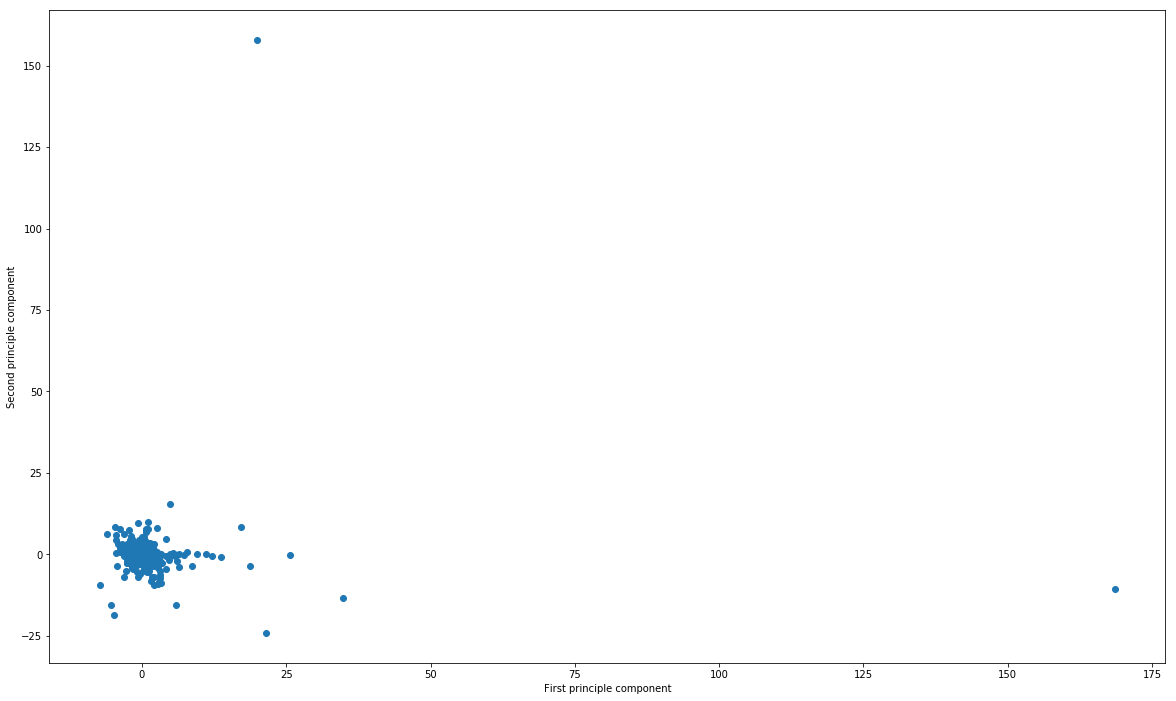

In [131]:
#Main

print("Loading Data....................")
Data,stopWord=loadData()
    
X,Y=splitData()

size=len(X)
size=6000

tokens,taggs,wordsTORemove =TokenizeData(X,3)

print("Loading Data Completed...........")
print("")
print("Processing Data..................")

tfidf=processData()

#Create Panda DataFrame
df=pd.DataFrame(tfidf)
df=np.transpose(df)

print("Data Processing Completed........")
print("")
print("Applying PCA.....................")

x_pca,scaled_data=applyPCA()

print("PCA Applied......................")
print("")
print("Traning Model....................")

#BreakData
X_train, X_test, y_train, y_test = train_test_split(x_pca, Y[:size],test_size=0.20,random_state=48)

print("Applying SVM.....................")


#Apply SVM
model = svm.SVC(random_state=20)
print("Model Trained....................")
print("")
print("Applying Model...................")

model.fit(X_train,y_train)
acc=model.score(X_test,y_test)

print("")
print("Accuracy= ",acc*100,"%")

plotData()

print("")